In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to /Users/danc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /Users/danc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danc/nltk_data...


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("imdb")

# Inspect dataset features
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [4]:
# Load the IMDb dataset from Hugging Face
from datasets import load_dataset
imdb = load_dataset("imdb")

In [5]:
# check the dataset split names
from datasets import get_dataset_split_names
get_dataset_split_names("imdb")

['train', 'test', 'unsupervised']

In [6]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
ds_train = imdb['train']
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
# EDA
# check the distribution of the labels
labels_train = pd.Series(ds_train['label'])
ax = labels_train.value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

In [20]:
# basic NLTK preprocessing
example_text = ds_train[0]['text']
example_text
tokens = nltk.word_tokenize(example_text)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

In [24]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner), ignoring contexts
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example_text)

{'neg': 0.04, 'neu': 0.922, 'pos': 0.038, 'compound': -0.1167}

In [26]:
# Run the polarity score on the entire training dataset
results_train = {}
counter = 0
for row in tqdm(ds_train, total=len(ds_train)):
    text = row['text']
    results_train[counter] = sia.polarity_scores(text)
    counter += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

In [29]:
vaders = pd.DataFrame(results_train).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders


,Id,neg,neu,pos,compound
0,0,0.040,0.922,0.038,-0.1167
1,1,0.085,0.869,0.046,-0.8648
2,2,0.068,0.798,0.133,0.8324
3,3,0.127,0.749,0.124,-0.0924
4,4,0.083,0.876,0.041,-0.9358
...,...,...,...,...,...
24995,24995,0.098,0.716,0.186,0.9136
24996,24996,0.116,0.744,0.140,0.6056
24997,24997,0.072,0.684,0.244,0.9799
24998,24998,0.075,0.803,0.122,0.9909


In [34]:
df_train = pd.DataFrame(ds_train)
df_train = df_train.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_train, how='left')
vaders

,Id,neg,neu,pos,compound,text,label
0,0,0.040,0.922,0.038,-0.1167,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,1,0.085,0.869,0.046,-0.8648,"""I Am Curious: Yellow"" is a risible and preten...",0
2,2,0.068,0.798,0.133,0.8324,If only to avoid making this type of film in t...,0
3,3,0.127,0.749,0.124,-0.0924,This film was probably inspired by Godard's Ma...,0
4,4,0.083,0.876,0.041,-0.9358,"Oh, brother...after hearing about this ridicul...",0
...,...,...,...,...,...,...,...
24995,24995,0.098,0.716,0.186,0.9136,A hit at the time but now better categorised a...,1
24996,24996,0.116,0.744,0.140,0.6056,I love this movie like no other. Another time ...,1
24997,24997,0.072,0.684,0.244,0.9799,This film and it's sequel Barry Mckenzie holds...,1
24998,24998,0.075,0.803,0.122,0.9909,'The Adventures Of Barry McKenzie' started lif...,1


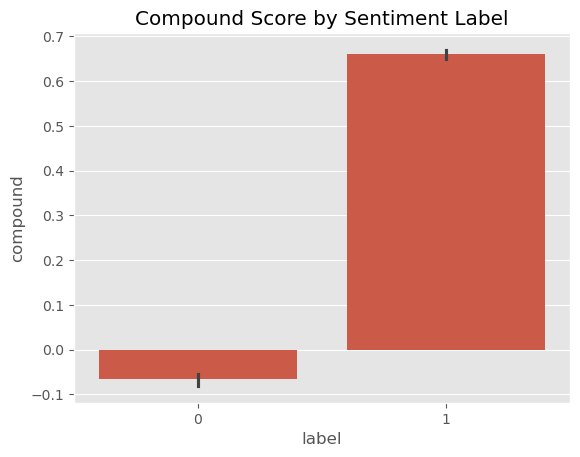

In [35]:
# plot VADER scores by sentiment label
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compound Score by Sentiment Label')
plt.show()

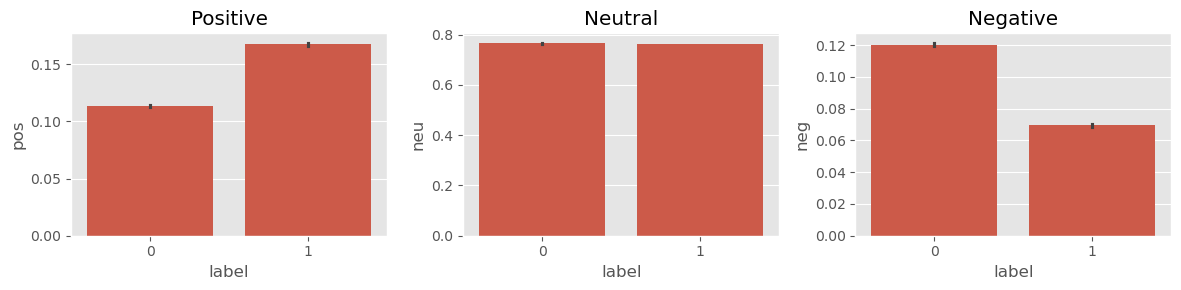

In [36]:
# plot VADER sub-scores by sentiment label
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [37]:
# Use the Roberta pretrained model for sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [38]:
# Get the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/Users/danc/anaconda3/envs/agents/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  # Prevent parallel downloads of the same file with a lock.


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [40]:
# Run the example text through the Roberta model and get the scores
encoded_text = tokenizer(example_text, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.5537571,
 'roberta_neu': 0.3769245,
 'roberta_pos': 0.069318384}

In [41]:
# Make a function to run the Roberta model on each entry
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
# Run the Roberta model on the training dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
# randomize the test set
ds_test = imdb['test']
ds_test


In [ ]:
# split a validation set from the test set
